# **Quantium Data preparation and Customer Analytics** <br>
TeYang Lau<br>
Created: 24/7/2020<br>
Last update: 31/8/2020<br>

<img src = 'https://assets.epicurious.com/photos/5d2dee06bcca5400095d4de4/16:9/w_2560%2Cc_limit/Taste_Test_Thin_Chips_HERO_071119_025.jpg' width=800>

## Project Goals
1. *Explore* customer transaction data and find interesting insights to chips **purchase behavior**
2. *Identify* **customer segments** that contribute to sales
3. *Investigate* which brand and size customers have **affinity** to 

### About this dataset
This data is provided courtesy of [Quantium](https://quantium.com/) via [InsideSherpa's Data Analytics Virtual Experience Program](https://www.insidesherpa.com/virtual-internships/prototype/NkaC7knWtjSbi6aYv/Data%20Analytics%20Virtual%20Experience%20Program). It contains customer segment data as well as customer transaction data on chips purchase.

### Findings
* EDA showed that **Kettle** and **Smiths** brand of chips brought in the largest revenue as well as quantities sold
* Products with **Salt** and **Sour Cream** tend to sell the most
* `Mainstream Young Singles/Couples` contributed to one of the highest sales due to their large customer pool but tend to purchase lower quantity of chips, so advertistments can be targeted towards this group to encourage more purchase
* Affinity analysis suggests that `Mainstream Young Singles/Couples` have affinity towards **Tyrrells** brand and **270g** product size


### What's in this notebook:
1. [Data Loading and Cleaning](#Data_loading)<br>
    1.1. [Clean Date](#CleanDate)<br>
    1.2. [Clean Product Name](#ProductName)<br>
    1.3. [Extract Product Brand](#ProductBrand)<br>
    1.4. [Remove Outliers](#Outliers)<br>
2. [Exploratory Data Analysis](#EDA)<br>
    2.1. [By Brand](#Brand)<br>
    2.2. [By Date](#Date)<br>
    2.3. [By Product Size](#Size)<br>
    2.4. [By Product Keywords](#Keywords)<br>
    2.5. [Customer Data](#Customer)<br>
    2.6. [Merge Data](#Merge)<br>
3. [Data Analysis](#Analysis)<br>
    3.1. [Total Sales and Quantity](#TotalSales)<br>
    3.2. [Total Sales Per Customer and Per Unique Customer](#TotalSalesPC)<br>
    3.3. [Total Quantity Purchased Per Customer and Per Unique Customer](#TotalQuantityPC)]<br>
    3.4. [Number of Unique Customers in Each Segment](#NumberOfCustomers)<br>
    3.5. [Price Paid Per Quantity Per Unique Customer](#PricePerQuantityPerCustomer)<br>
    
4. [Market Basket and Affinity Analysis](#Affinity)<br>
    4.1. [Market Basket](#Basket)<br>
    4.2. [Affinity to Brand and Size](#AffinityBrandSize)<br>
5. [Conclusion](#Conclusion)


<a id='Data_loading'></a>
## **1. Data Loading and Cleaning** ##

In [122]:
import numpy as np
import pandas as pd
import datetime as dt
import re
from nltk.util import ngrams

import matplotlib.pyplot as plt
import seaborn as sns
from pywaffle import Waffle
import matplotlib.dates as mdates

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [123]:
customer = pd.read_csv('./Data/QVI_purchase_behaviour.csv')
dat = pd.read_excel('./Data/QVI_transaction_data.xlsx')

customer.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [124]:
# check for missing values
customer.isnull().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [125]:
dat.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [126]:
dat.isnull().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

<a id='CleanDate'></a>
## 1.1. Clean Date

In [127]:
# Change excel date to real date
dat['DATE'] = pd.TimedeltaIndex(dat['DATE'], unit='d') + dt.datetime(1899, 12, 30)

In [128]:
dat.head(10)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
5,2019-05-19,4,4074,2982,57,Old El Paso Salsa Dip Tomato Mild 300g,1,5.1
6,2019-05-16,4,4149,3333,16,Smiths Crinkle Chips Salt & Vinegar 330g,1,5.7
7,2019-05-16,4,4196,3539,24,Grain Waves Sweet Chilli 210g,1,3.6
8,2018-08-20,5,5026,4525,42,Doritos Corn Chip Mexican Jalapeno 150g,1,3.9
9,2018-08-18,7,7150,6900,52,Grain Waves Sour Cream&Chives 210G,2,7.2


<a id='ProductName'></a>
## 1.2. Clean Product Name 

In [129]:
# Extract product size
dat['PROD_SIZE'] = [re.search(r"[0-9]+(g|G)", p).group(0).replace('G','').replace('g','') for p in dat['PROD_NAME']]


Some of the products are not chips, most of them with the word **'Salsa'**. However, some salsa are actually chips with 'salsa' in their product names. We will need to remove those that are salsa and not chips.

In [130]:
# get unique products
dat['PROD_NAME'].unique()[:10] 

array(['Natural Chip        Compny SeaSalt175g',
       'CCs Nacho Cheese    175g',
       'Smiths Crinkle Cut  Chips Chicken 170g',
       'Smiths Chip Thinly  S/Cream&Onion 175g',
       'Kettle Tortilla ChpsHny&Jlpno Chili 150g',
       'Old El Paso Salsa   Dip Tomato Mild 300g',
       'Smiths Crinkle Chips Salt & Vinegar 330g',
       'Grain Waves         Sweet Chilli 210g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Grain Waves Sour    Cream&Chives 210G'], dtype=object)

In [131]:
### Remove salsa dips
dat = dat[~dat['PROD_NAME'].isin(['Old El Paso Salsa   Dip Tomato Mild 300g',
'Old El Paso Salsa   Dip Chnky Tom Ht300g',
'Woolworths Mild     Salsa 300g',
'Old El Paso Salsa   Dip Tomato Med 300g',
'Woolworths Medium   Salsa 300g',
'Doritos Salsa Mild  300g',
'Doritos Salsa       Medium 300g'])].reset_index(drop=True)

Here we clean the product names so that abbrieviations like **Slt** will be converted to their original form **Salt**, and we also split up words that are meant to be separated. `&` and product size are also removed.

In [132]:
### Clean up product names
# https://www.guru99.com/python-regular-expressions-complete-tutorial.html

# replace & with space and remove multiple spaces
dat['PROD_NAME'] = [" ".join(p.replace('&',' ').split()) for p in dat['PROD_NAME']]
# remove digits that are followed by grams
dat['PROD_NAME'] = [re.sub(r"\s*[0-9]+(g|G)", r"", p) for p in dat['PROD_NAME']]


In [133]:
def replaceWords(string):
    # specific
    string = re.sub(r"SeaSalt", "Sea Salt", string)
    string = re.sub(r"Frch/Onin", "French Onion", string)
    string = re.sub(r"Cheddr Mstrd", "Cheddar Mustard", string)
    string = re.sub(r"Jlpno Chili", "Jalapeno Chilli", string)
    string = re.sub(r"Swt/Chlli Sr/Cream", "Sweet Chilli Sour Cream", string)
    string = re.sub(r"SourCream", "Sour Cream", string)
    string = re.sub(r"Tmato Hrb Spce", "Tomato Herb Spice", string)
    string = re.sub(r"S/Cream", "Sour Cream", string)
    string = re.sub(r"ChipsFeta", "Chips Feta", string)
    string = re.sub(r"ChpsHny", "Chips Honey", string)
    string = re.sub(r"FriedChicken", "Fried Chicken", string)
    string = re.sub(r"OnionDip", "Onion Dip", string)
    string = re.sub(r"SweetChili", "Sweet Chilli", string)
    string = re.sub(r"PotatoMix", "Potato Mix", string)
    string = re.sub(r"Seasonedchicken", "Seasoned Chicken", string)
    string = re.sub(r"CutSalt/Vinegr", "Cut Salt Vinegar", string)
    string = re.sub(r"ChpsBtroot", "Chips Beetroot", string)
    string = re.sub(r"ChipsBeetroot", "Chips Beetroot", string)
    string = re.sub(r"ChpsFeta", "Chips Feta", string)
    string = re.sub(r"OnionStacked", "Onion Stacked", string)
    string = re.sub(r"Ched", "Cheddar", string)
    string = re.sub(r"Strws", "Straws", string)
    string = re.sub(r"Slt", "Salt", string)
    string = re.sub(r"Chikn", "Chicken", string)
    string = re.sub(r"Rst", "Roast", string)
    string = re.sub(r"Vinegr", "Vinegar", string)
    string = re.sub(r"Mzzrlla", "Mozzarella", string)
    string = re.sub(r"Originl", "Original", string)
    string = re.sub(r"saltd", "Salted", string)
    string = re.sub(r"Swt", "Sweet", string)
    string = re.sub(r"Chli", "Chilli", string)
    string = re.sub(r"Hony", "Honey", string)
    string = re.sub(r"Chckn", "Chicken", string)
    string = re.sub(r"Chp", "Chip", string)
    string = re.sub(r"Btroot", "Beetroot", string)
    string = re.sub(r"Chs", "Cheese", string)
    string = re.sub(r"Crm", "Cream", string)
    string = re.sub(r"Orgnl", "Original", string)

    return string

dat['PROD_NAME'] = [replaceWords(s) for s in dat['PROD_NAME']]

dat['PROD_NAME'].replace('Infzns Crn Crnchers Tangy Gcamole',
'Infuzions Corn Crunchers Tangy Guacamole', inplace=True)

In [134]:
dat['PROD_NAME'].unique()[:10]

array(['Natural Chip Compny Sea Salt', 'CCs Nacho Cheese',
       'Smiths Crinkle Cut Chips Chicken',
       'Smiths Chip Thinly Sour Cream Onion',
       'Kettle Tortilla Chips Honey Jalapeno Chilli',
       'Smiths Crinkle Chips Salt Vinegar', 'Grain Waves Sweet Chilli',
       'Doritos Corn Chip Mexican Jalapeno',
       'Grain Waves Sour Cream Chives', 'Kettle Sensations Siracha Lime'],
      dtype=object)

<a id='ProductBrand'></a>
## 1.3. Extract Product Brand 

Here we standardize all the product brands (e.g, Red Rock Deli becomes RRD) and then we extract the brand name from the first word of the product name. 

In [135]:
def replaceBrands(string):
    # specific
    string = re.sub(r"Red Rock Deli", "RRD", string)
    string = re.sub(r"Dorito", "Doritos", string)
    string = re.sub(r"Doritoss", "Doritos", string)
    string = re.sub(r"Smith", "Smiths", string)
    string = re.sub(r"Smithss", "Smiths", string)
    string = re.sub(r"GrnWves", "Grain Waves", string)
    string = re.sub(r"Woolworths", "WW", string) 
    string = re.sub(r"Snbts", "Sunbites", string) 

    return string

# standardize common brand names
dat['PROD_NAME'] = [replaceBrands(s) for s in dat['PROD_NAME']]

# get brand name from first word
dat['brand'] = [s.split(' ')[0] for s in dat['PROD_NAME']]

In [136]:
dat.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_SIZE,brand
0,2018-10-17,1,1000,1,5,Natural Chip Compny Sea Salt,2,6.0,175,Natural
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese,3,6.3,175,CCs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly Sour Cream Onion,5,15.0,175,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla Chips Honey Jalapeno Chilli,3,13.8,150,Kettle


<a id='Outliers'></a>
## 1.4. Remove Outliers

In [137]:
dat.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,249670.000000,2.496700e+05,2.496700e+05,249670.000000,249670.000000,249670.000000
mean,135.044278,1.355203e+05,1.351234e+05,56.294288,1.907762,7.293966
std,76.773591,8.065746e+04,7.813155e+04,33.528758,0.657126,3.071796
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001625e+04,6.757425e+04,27.000000,2.000000,5.700000
50%,130.000000,1.303600e+05,1.351475e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030798e+05,2.026338e+05,86.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


In [138]:
# remove outlier
dat = dat[dat['PROD_QTY'] < 200].reset_index(drop=True)

<a id='EDA'></a>
## 2. Exploratory Data Analysis

<a id='Brand'></a>
## 2.1. By Brand

First we look at the number of packages sold as well as the number of transaction for each chip brand. It appears that **Kettle** is the brand that has the highest quantities sold, followed by **Smiths**. **French Fries** and **The Natural Chip Co.** came in last and second last respectively. However, this could be due to some people purchasing more of a certain brand than another brand, which means that having the most quantity sold doesn't mean that it will be the ***most popular*** among customers. Transactions by brand gives a better idea but it could also be that some people buy lots of a brand in a single transaction. We will have to control for these in subsequent analyses.

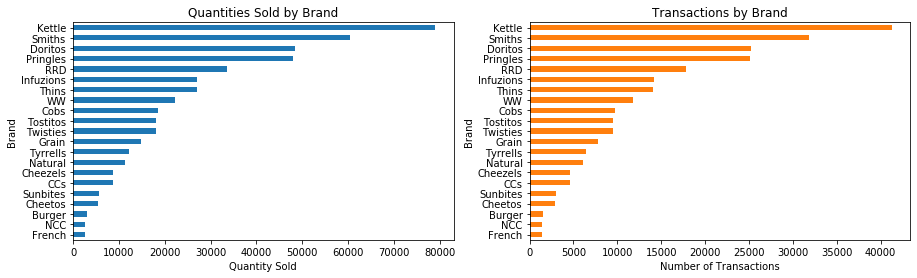

In [139]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

# Product quantity sales by brand
ax1=plt.subplot(121)
dat.groupby(['brand'], as_index=False).agg({'PROD_QTY': 'sum'}).sort_values('PROD_QTY').plot.barh(x='brand',legend=False, ax=ax1)

ax1.set_xlabel('Quantity Sold')
ax1.set_ylabel('Brand')
ax1.set_title('Quantities Sold by Brand')

ax2=plt.subplot(122)
dat.groupby(['brand'], as_index=False)[['TXN_ID']].count().sort_values('TXN_ID').plot.barh(x='brand',color='#ff7f0e', legend=False, ax=ax2)
ax2.set_xlabel('Number of Transactions')
ax2.set_ylabel('Brand')
ax2.set_title('Transactions by Brand')

plt.show()

<a id='Date'></a>
## 2.2. By Date

Here we look at the number of chips sold throughout the whole year. We see an increase during December, possibly due to people stocking up for Christmas. There were also dips around August and May. Zooming in on **December**, we can see a trend in increasing sales coming up towards Christmas, which then dropped to 0 as the supermarket is closed on the holiday.


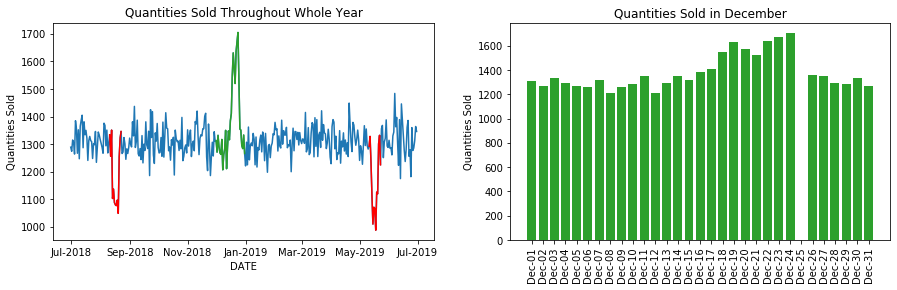

In [140]:
## Plot quantities sold by date
bydate = dat.groupby('DATE').agg({'PROD_QTY': 'sum'}).reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

ax1=plt.subplot(121)
sns.lineplot(x="DATE", y="PROD_QTY", data=bydate, ax=ax1)
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
sns.lineplot(x="DATE", y="PROD_QTY", data=bydate[(bydate['DATE'] > '2018-11-30') & (bydate['DATE'] < '2019-01-01')], color='#2ca02c', ax=ax1)
sns.lineplot(x="DATE", y="PROD_QTY", data=bydate[(bydate['DATE'] > '2018-08-10') & (bydate['DATE'] < '2018-08-24')], color='red', ax=ax1)
sns.lineplot(x="DATE", y="PROD_QTY", data=bydate[(bydate['DATE'] > '2019-05-10') & (bydate['DATE'] < '2019-05-24')], color='red', ax=ax1)
plt.ylabel('Quantities Sold')
plt.title('Quantities Sold Throughout Whole Year')


## Plot December quantities sold
# filter december
december = bydate[bydate['DATE'].isin(pd.date_range(start="2018-12-01",end="2018-12-31").tolist())]

# fill in missing dec data
december = december.set_index('DATE').reindex(pd.date_range(start="2018-12-01",end="2018-12-31"), fill_value=0)

ax2=plt.subplot(122)
ax2.bar(december.index,december['PROD_QTY'],color='#2ca02c')
ax2.set_xticks(december.index)
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b-%d"))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%b-%d"))
ax2.tick_params(axis='x', rotation=90) 
plt.ylabel('Quantities Sold')
plt.title('Quantities Sold in December')
plt.show()

<a id='Size'></a>
## 2.3. By Product Size

It's also interesting to look at quantities sold by product size and it appears that **175g** is the most popular size.

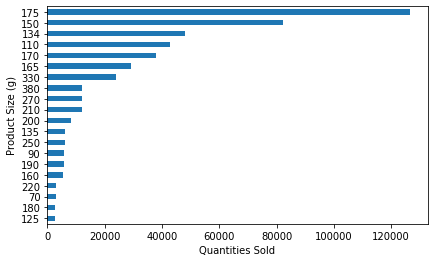

In [141]:
# Product Size

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,4))

ax1=plt.subplot(121)
dat.groupby('PROD_SIZE').agg({'PROD_QTY': 'sum'}).sort_values('PROD_QTY').reset_index().plot.barh(x='PROD_SIZE', legend=False, ax=ax1)
ax1.set_ylabel('Product Size (g)')
ax1.set_xlabel('Quantities Sold')

plt.show()

<a id='Keywords'></a>
## 2.4. By Product Keywords

Here we look at words and bigrams in the product names that are the most popular.

In [142]:
# Function for counting product keywords
def count_keywords(df):
    words_freq = {}
    for c,p in enumerate(df['PROD_NAME']):
        for word in p.split():
            if word in words_freq:
                words_freq[word] += df['PROD_QTY'][c]
            else:
                words_freq[word] = df['PROD_QTY'][c]
    
    return words_freq

# Function for generating ngrams
def generate_ngrams(text, n):
    words = text.split()
    return [' '.join(ngram) for ngram in list(ngrams(words, n))]

# Function for counting product bigrams
def count_bigrams(df):
    bigrams_freq = {}
    for c,p in enumerate(df['PROD_NAME']):
        for ngram in generate_ngrams(p, 2):
            if ngram in bigrams_freq:
                bigrams_freq[ngram] += df['PROD_QTY'][c]
            else:
                bigrams_freq[ngram] = df['PROD_QTY'][c]
    return bigrams_freq

words_freq = count_keywords(dat)
bigrams_freq = count_bigrams(dat)

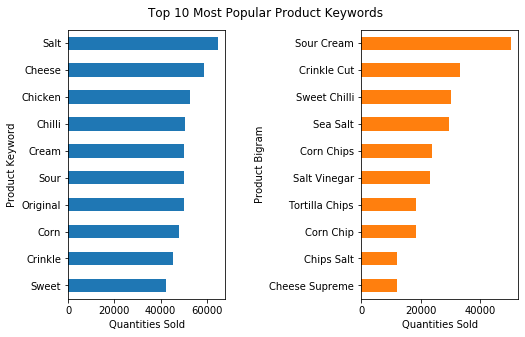

In [143]:
# get top keywords
topwords = pd.DataFrame(words_freq.items(), columns=['word','freq']).sort_values('freq')
topwords = topwords[~topwords.word.isin(['Chips','Kettle','Smiths','Doritos','Pringles'])]

# get top bigrams
topbigrams = pd.DataFrame(bigrams_freq.items(), columns=['bigram','freq']).sort_values('freq')
topbigrams = topbigrams[~topbigrams.bigram.isin(['Smiths Crinkle','Doritos Corn','Thins Chips','Cobs Popd','Kettle Tortilla','Grain Waves','Kettle Sensations','Kettle Sweet','Tyrrells Crisps','Twisties Cheese'])]

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,5))

ax1 = plt.subplot(121)
topwords[-10:].plot.barh(x='word', legend=False, ax=ax1)
ax1.set_xlabel('Quantities Sold')
ax1.set_ylabel('Product Keyword')

ax2 = plt.subplot(122)
topbigrams[-10:].plot.barh(x='bigram', color='#ff7f0e', legend=False, ax=ax2)
ax2.set_xlabel('Quantities Sold')
ax2.set_ylabel('Product Bigram')

fig.tight_layout(pad=3.0)
plt.suptitle('Top 10 Most Popular Product Keywords')
plt.show()

We can see that **salt** and **cheese** have the most quantities sold. When looking at bigrams, **sour cream** is the most popular. Below is a word cloud for the keywords and bigrams.

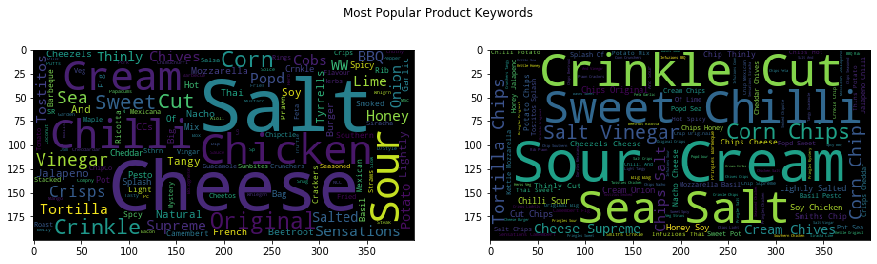

In [144]:
# Plot wordcloud of keywords and bigrams
from wordcloud import WordCloud

rem_list = ['Chips','Kettle','Smiths','Doritos','Pringles','Chip', 'Infuzions', 'RRD', 'Thins', 'Twisties', 'Grain', 'Waves']
[words_freq.pop(key) for key in rem_list] 

rem_list = ['Smiths Crinkle','Doritos Corn','Thins Chips','Cobs Popd','Kettle Tortilla','Grain Waves','Kettle Sensations','Kettle Sweet','Tyrrells Crisps','Twisties Cheese']
[bigrams_freq.pop(key) for key in rem_list] 

plt.figure(figsize=(15,4))
plt.subplot(121)
wc = WordCloud(background_color="black").generate_from_frequencies(words_freq)
plt.imshow(wc)
plt.subplot(122)
wc = WordCloud(background_color="black").generate_from_frequencies(bigrams_freq)
plt.imshow(wc)
plt.suptitle('Most Popular Product Keywords')
plt.show()

<a id='Customer'></a>
## 2.5. Customer Data

We now explore the customer data, which contains their lifestage and their premium class.

In [145]:
customer.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


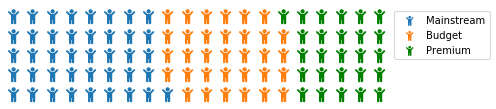

In [146]:
## Waffle chart for customer class
premium = dict(customer['PREMIUM_CUSTOMER'].value_counts()/len(customer)*100)

plt.figure(figsize=(7,5),
    FigureClass=Waffle, 
    rows=5, 
    values=premium, 
    colors=["#1f77b4", "#ff7f0e", "green"],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons='child', 
    font_size=15, 
    icon_legend=True)
    
plt.show()

According to the waffle chart, the classes are quite evenly split, with more mainstreams followed by budget customers. 

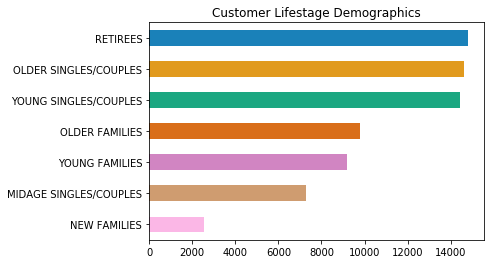

In [147]:
# Plot customer lifestage counts
customer.LIFESTAGE.value_counts().plot(kind='barh', alpha=.9, color=sns.color_palette("colorblind"), title='Customer Lifestage Demographics').invert_yaxis()

Retirees, older and younger singles and couples are also the majority of the customer pool.

<a id='Merge'></a>
## 2.6. Merge Data

We merge the customer data and the transaction data to allow further and deeper analyses. We also check if there are any duplicates and null values after merging.

In [148]:
# Merge
alldat = dat.merge(customer, on='LYLTY_CARD_NBR')

print('No Duplicates:', len(alldat) == len(alldat)) # check same rows, no duplicates
print('Number of Nulls:', alldat.isnull().sum().sum()) # check for nulls

No Duplicates: True
Number of Nulls: 0


<a id='Analysis'></a>
## 3. Data Analysis

Now we can dive deeper into the data and investigate specific customer segments and how sales are contributed by these segments.


In [149]:
alldat.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_SIZE,brand,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny Sea Salt,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2018-11-10,1,1307,346,96,WW Original Stacked Chips,2,3.8,160,WW,MIDAGE SINGLES/COUPLES,Budget
3,2019-03-09,1,1307,347,54,CCs Original,1,2.1,175,CCs,MIDAGE SINGLES/COUPLES,Budget
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget


<a id='TotalSales'></a>
## 3.1. Total Sales and Quantity

Here we separate the customer segments by lifestage and their premium class and look at the sales and quantities sold by each of these segments.

In [150]:
# Sum up for each group 
life_prem = alldat.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).agg({'TOT_SALES':'sum','PROD_QTY':'sum', 'TXN_ID':'count'}).reset_index().sort_values('TOT_SALES') # sort by TOT_SALES
life_prem['Group'] = life_prem['LIFESTAGE'] + '_' + life_prem['PREMIUM_CUSTOMER']

# sort by PROD_QTY
life_prem_qty = life_prem.sort_values('PROD_QTY')

In [151]:
# Function for Lollipop chart
def loll_plot(df1,x,y,xlabel,title,firstX):
    
    my_color=np.where(df1[x]==firstX, '#ff7f0e', '#1f77b4')
    my_color[0] = 'red'
    my_size=np.where(df1[x]==firstX, 70, 30)
    my_size[0] = '70'

    plt.hlines(y=np.arange(0,len(df1)),xmin=0,xmax=df1[y],color=my_color)
    plt.scatter(df1[y], np.arange(0,len(df1)), color=my_color, s=my_size)
    plt.yticks(np.arange(0,len(df1)), df1[x])
    plt.xlabel(xlabel)
    plt.title(title)

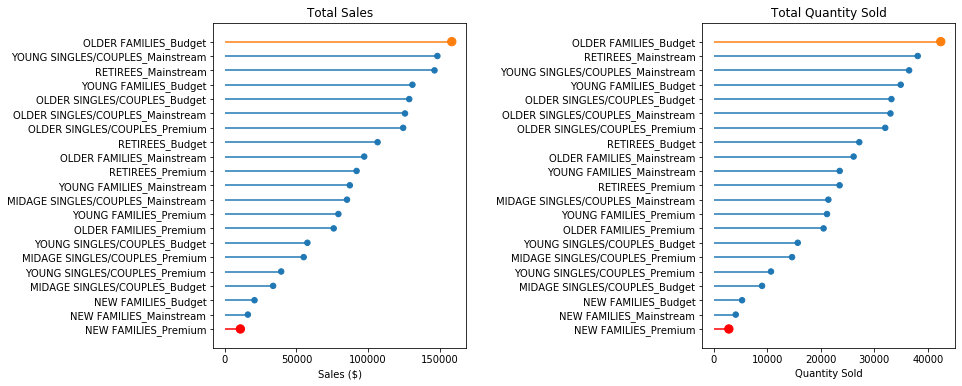

In [152]:
## Sales and Quantity Sold by each Segment
fig = plt.figure(figsize=(14,6))

ax1 = plt.subplot(121)
loll_plot(life_prem,'Group','TOT_SALES','Sales ($)','Total Sales','OLDER FAMILIES_Budget')
plt.xticks(ticks=[0,50000,100000,150000])

ax2 = plt.subplot(122)
loll_plot(life_prem_qty,'Group','PROD_QTY','Quantity Sold','Total Quantity Sold','OLDER FAMILIES_Budget')

fig.tight_layout(pad=3.0)
plt.show()

We can see that `Budget Older Families`, `Mainstream Young Singles/Couples` and `Mainstream Retirees` contribute the most to chip sales and quantities sold. However, this could be due to some segments having more customers who purchase chips. A better way is to compute the sales **by each customer**.

<a id='TotalSalesPC'></a>
## 3.2. Total Sales Per Customer and Per Unique Customer

In [153]:
# Get number of unique customers in each group
life_prem_pc = alldat[['LYLTY_CARD_NBR','LIFESTAGE','PREMIUM_CUSTOMER']].drop_duplicates('LYLTY_CARD_NBR').reset_index(drop=True).groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).size().reset_index(name='Count').sort_values('Count').merge(life_prem, on=['LIFESTAGE','PREMIUM_CUSTOMER'])

life_prem_pc['SALES_PER_C'] = life_prem_pc['TOT_SALES']/life_prem_pc['TXN_ID']
life_prem_pc['SALES_PER_UC'] = life_prem_pc['TOT_SALES']/life_prem_pc['Count']
life_prem_pc = life_prem_pc.sort_values('SALES_PER_C')

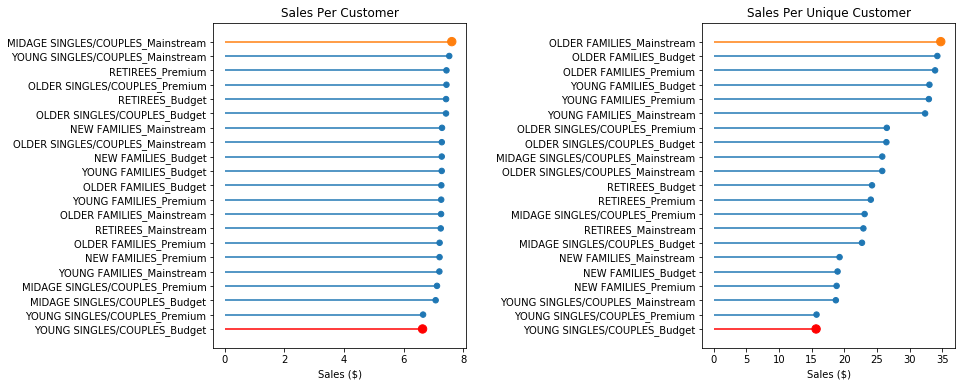

In [154]:
## Sales by each Segment per Customer and per Unique Customer
fig = plt.figure(figsize=(14,6))

ax1 = plt.subplot(121)
loll_plot(life_prem_pc,'Group','SALES_PER_C','Sales ($)','Sales Per Customer','MIDAGE SINGLES/COUPLES_Mainstream')

life_prem_pc = life_prem_pc.sort_values('SALES_PER_UC')
ax2 = plt.subplot(122)
loll_plot(life_prem_pc,'Group','SALES_PER_UC','Sales ($)','Sales Per Unique Customer','OLDER FAMILIES_Mainstream')

fig.tight_layout(pad=3.0)
plt.show()

We also computed the sales **per unique customer** as some segments could have higher number of sales due to repeat transactions by the same customers. We can see that they tell a different story. Notice that the `Sales Per Unique Customer` plot has a higher sales per segment and this is because their are multiple customers who made multiple transactions in the given year.  It seems that `Older Families` and `Young Families` pay the most for chips in the given year.

<a id='TotalQuantityPC'></a>
## 3.3. Total Quantity Purchased Per Customer and Per Unique Customer

In [155]:
life_prem_pc['QTY_PER_C'] = life_prem_pc['PROD_QTY']/life_prem_pc['TXN_ID']
life_prem_pc['QTY_PER_UC'] = life_prem_pc['PROD_QTY']/life_prem_pc['Count']
life_prem_pc = life_prem_pc.sort_values('QTY_PER_C')

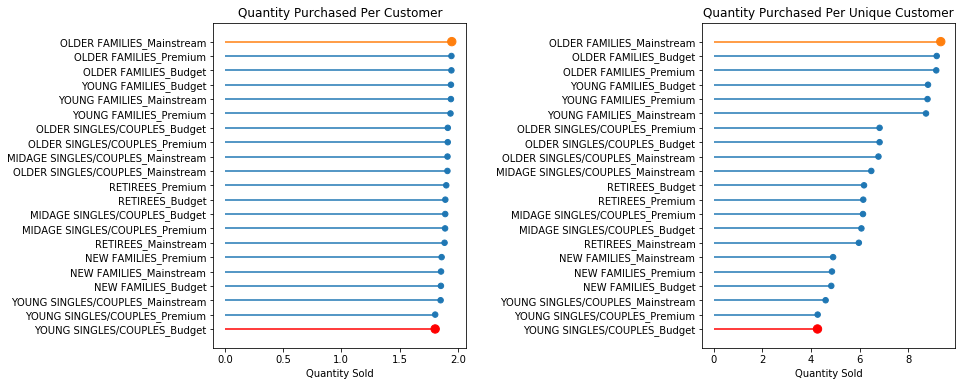

In [156]:

fig = plt.figure(figsize=(14,6))

ax1 = plt.subplot(121)
loll_plot(life_prem_pc,'Group','QTY_PER_C','Quantity Sold','Quantity Purchased Per Customer','OLDER FAMILIES_Mainstream')

life_prem_pc = life_prem_pc.sort_values('QTY_PER_UC')
ax2 = plt.subplot(122)
loll_plot(life_prem_pc,'Group','QTY_PER_UC','Quantity Sold','Quantity Purchased Per Unique Customer','OLDER FAMILIES_Mainstream')

fig.tight_layout(pad=3.0)
plt.show()

When we look at quantities sold, the same pattern appears. `Older Families` and `Young Families` purchase the most chips in the given year.

<a id='NumberOfCustomers'></a>
## 3.4. Number of Unique Customers in Each Segment

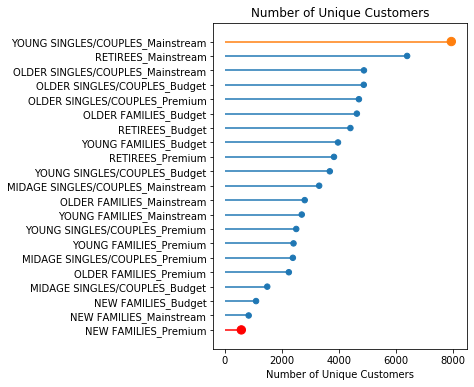

In [157]:
life_prem_pc = life_prem_pc.sort_values('Count')
fig = plt.figure(figsize=(10,6))
ax1 = plt.subplot(121)
loll_plot(life_prem_pc,'Group','Count','Number of Unique Customers','Number of Unique Customers','YOUNG SINGLES/COUPLES_Mainstream')

We can see that `Mainstream Young Singles/Couples` and `Mainstream Retirees` have a lot more customers, which might explain their higher sales, while `Budget Retirees` do not have as large a customer base, which might explain why the above `Per Unique Customer` results. 

So what we can conclude is the there are more `Mainstream Young Singles/Couples` and `Mainstream Retiress`, which lead to more sales by this segments, although *each of the customers* in these segments do not spend the highest total in a year on chips. On the other hand, while there are not as many `Budget Older Families`, *each of the customers* in this segment tend to purchase more chips, leading to high total sales. 

<a id='PricePerQuantityPerCustomer'></a>
## 3.5. Price Paid Per Quantity Per Unique Customer


Finally, let us look at how much each customer in each of the segments are willing to pay for each packet of chips. We see that `Mainstream Young and Midage Singles/Couples` are more willing to pay more for each pack of chips.

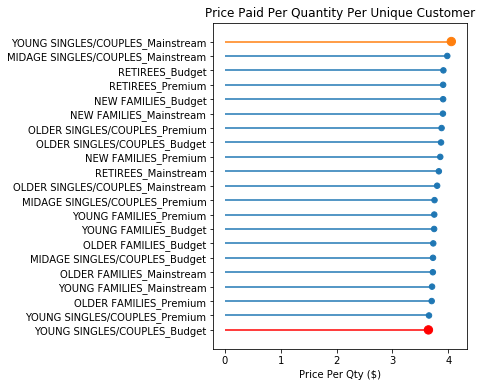

In [158]:
alldat['PRICE_PER_UNIT'] = alldat['TOT_SALES']/alldat['PROD_QTY'] # get price per unit
# get price per unit of each customer then groupby lifestage and premium_customer to get average per group
price_per_unit = alldat.groupby('LYLTY_CARD_NBR').agg({'PRICE_PER_UNIT':'mean'}).reset_index().merge(alldat[['LYLTY_CARD_NBR','LIFESTAGE','PREMIUM_CUSTOMER']], on='LYLTY_CARD_NBR').groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).agg({'PRICE_PER_UNIT':'mean'}).reset_index().sort_values('PRICE_PER_UNIT')
price_per_unit['Group'] = price_per_unit['LIFESTAGE'] + '_' + price_per_unit['PREMIUM_CUSTOMER']


fig = plt.figure(figsize=(10,6))
ax1 = plt.subplot(121)
loll_plot(price_per_unit,'Group','PRICE_PER_UNIT','Price Per Qty ($)','Price Paid Per Quantity Per Unique Customer','YOUNG SINGLES/COUPLES_Mainstream')


To conclude, given that the `Mainstream Young Singles/Couples` contributed to the most sales, have the largest number of customers but tend to purchase lower quantities of chips, perhaps this group can be further targeted for more advertisements/recommendations/promotions on certain brands to encourage more purchase and for purchasing slightly more expensive chip brands.

`Mainstream Retirees` tend to be the same as `Mainstream Young Singles/Couples`, except that they tend to purchase more chips and slightly cheaper chips. The general strategy would be the same except to promote cheaper brands to them.

Meanwhile, `Budget Older Families` also contributed to the most sales, and they tend to buy lots of chips, but there are not as much of them in the customer base. Therefore, the strategy would be to attract more of this segment to increase the pool size.

This can help to drive up total sales and profits.

<a id='Affinity'></a>
## 4. Market Basket and Affinity Analysis

Affinity analysis or market basket analysis, is a data mining technique used to understand the purchase behavior of customers. For example, market basket analysis might tell us that customers who purchase Doritos also tend to buy Tyrrells in a certain year or transaction, so putting both items on promotion at the same time would not create a significant increase in revenue, while a promotion involving just one of the items would likely drive sales of the other.

**Conditional Rule:**
IF {Kettle} THEN {Doritos}

### Support
A collection of items purchased by a customer is an **`itemset`**. The set of items on the left-hand side (Kettle in the example above) is the **`antecedent`** of the rule, while the one to the right (Doritos) is the **`consequent`**.  The probability that the antecedent event will occur, i.e., a customer will buy a sandwich and cookies, is the **`support`** of the rule. That simply refers to the relative frequency that an itemset appears in transactions. The support of an item or item combination helps to identify keystone products. Hence, if a sandwich and cookies have high support, then they can be priced to attract people to the store.

### Confidence
The probability that a customer will purchase a drink on the condition of purchasing a sandwich and cookies is referred to as the **`confidence`** of the rule. Confidence can be used for product placement strategy and increasing profitability. Placing high margin items near associated high confidence (driver) items can increase the overall margin on purchases.

### Lift
The **`lift`** of the rule is the ratio of the support of the left-hand side of the rule (Kettle) co-occurring with the right-hand side (Doritos), divided by the probability that the left-hand side and right-hand side co-occur if the two are independent. A **lift greater than 1** suggests that the presence of the antecedent increases the chances that the consequent will occur in a given transaction

**Lift below 1** indicates that purchasing the antecedent reduces the chances of purchasing the consequent in the same transaction. Note: This could indicate that the items are seen by customers as alternatives to each other

When the **lift is 1**, then purchasing the antecedent makes no difference on the chances of purchasing the consequent

<a id='Basket'></a>
## 4.1 Market Basket

Here we will focus on `Mainstream Young Singles/Couples` and the purchases they made throughout the year to understand their affinity to the brands and product sizes of chips.

In [160]:
basket = (alldat[(alldat['LIFESTAGE']=='YOUNG SINGLES/COUPLES') & (alldat['PREMIUM_CUSTOMER']=='Mainstream')]
        .groupby(['LYLTY_CARD_NBR','brand'])['PROD_QTY']
        .sum().unstack().reset_index().fillna(0)
        .set_index('LYLTY_CARD_NBR'))

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)
basket_sets


brand,Burger,CCs,Cheetos,Cheezels,Cobs,Doritos,French,Grain,Infuzions,Kettle,...,Natural,Pringles,RRD,Smiths,Sunbites,Thins,Tostitos,Twisties,Tyrrells,WW
LYLTY_CARD_NBR,,,,,,,,,,,,,,,,,,,,,
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1010,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1018,0,0,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
1020,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1060,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272391,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2330041,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2330321,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [161]:
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.103657,(Cobs)
1,0.259899,(Doritos)
2,0.078689,(Grain)
3,0.142875,(Infuzions)
4,0.386507,(Kettle)
5,0.255738,(Pringles)
6,0.102018,(RRD)
7,0.207818,(Smiths)
8,0.135813,(Thins)
9,0.105675,(Tostitos)


In [162]:
rules = association_rules(frequent_itemsets, metric="lift")
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Kettle),(Doritos),0.386507,0.259899,0.089786,0.232300,0.893809,-0.010667,0.964050
1,(Doritos),(Kettle),0.259899,0.386507,0.089786,0.345463,0.893809,-0.010667,0.937294
2,(Kettle),(Pringles),0.386507,0.255738,0.091299,0.236215,0.923663,-0.007546,0.974440
3,(Pringles),(Kettle),0.255738,0.386507,0.091299,0.357002,0.923663,-0.007546,0.954113
4,(Smiths),(Kettle),0.207818,0.386507,0.077175,0.371359,0.960809,-0.003148,0.975904


We can see that the lift are all close to 1, suggesting that the antecedents of each of the itemsets makes no difference on the chances of purchasing the consequent. 

<a id='AffinityBrandSize'></a>
## 4.2. Affinity to Brand and Size

As a final analysis, let us compute an affinity score for each of the product brand and sizes to see which brand and size `Mainstream Young Singles/Couples` tend to buy more often.

In [163]:
## Affinity to Brand

young_mainstream = alldat[(alldat['LIFESTAGE']=='YOUNG SINGLES/COUPLES') & (alldat['PREMIUM_CUSTOMER']=='Mainstream')]
quantity_bybrand = young_mainstream.groupby(['brand'])[['PROD_QTY']].sum().reset_index()
quantity_bybrand.PROD_QTY = quantity_bybrand.PROD_QTY / young_mainstream.PROD_QTY.sum()
quantity_bybrand = quantity_bybrand.rename(columns={"PROD_QTY": "Targeted_Segment"})

other_segments = pd.concat([alldat, young_mainstream]).drop_duplicates(keep=False) # remove young_mainsream
quantity_bybrand_other = other_segments.groupby(['brand'])[['PROD_QTY']].sum().reset_index()
quantity_bybrand_other.PROD_QTY = quantity_bybrand_other.PROD_QTY / other_segments.PROD_QTY.sum()
quantity_bybrand_other = quantity_bybrand_other.rename(columns={"PROD_QTY": "Other_Segment"})

quantity_bybrand = quantity_bybrand.merge(quantity_bybrand_other, on ='brand')
quantity_bybrand['Affinitytobrand'] = quantity_bybrand['Targeted_Segment'] / quantity_bybrand['Other_Segment']
quantity_bybrand = quantity_bybrand.sort_values('Affinitytobrand')

quantity_bybrand.head()


,brand,Targeted_Segment,Other_Segment,Affinitytobrand
0,Burger,0.002903,0.006518,0.445442
20,WW,0.023912,0.048840,0.489601
15,Sunbites,0.006300,0.012431,0.506797
1,CCs,0.011093,0.018671,0.594138
10,NCC,0.003616,0.005803,0.623006


In [164]:
## Affinity to Size

quantity_bysize = young_mainstream.groupby(['PROD_SIZE'])[['PROD_QTY']].sum().reset_index()
quantity_bysize.PROD_QTY = quantity_bysize.PROD_QTY / young_mainstream.PROD_QTY.sum()
quantity_bysize = quantity_bysize.rename(columns={"PROD_QTY": "Targeted_Segment"})

quantity_bysize_other = other_segments.groupby(['PROD_SIZE'])[['PROD_QTY']].sum().reset_index()
quantity_bysize_other.PROD_QTY = quantity_bysize_other.PROD_QTY / other_segments.PROD_QTY.sum()
quantity_bysize_other = quantity_bysize_other.rename(columns={"PROD_QTY": "Other_Segment"})

quantity_bysize = quantity_bysize.merge(quantity_bysize_other, on='PROD_SIZE')
quantity_bysize['Affinitytosize'] = quantity_bysize['Targeted_Segment'] / quantity_bysize['Other_Segment']
quantity_bysize = quantity_bysize.sort_values('Affinitytosize')

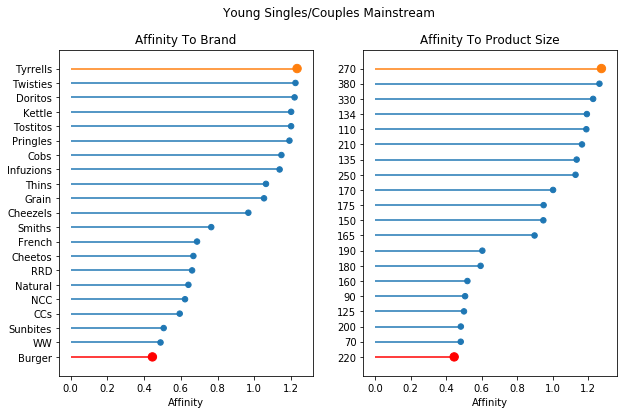

In [165]:

fig = plt.figure(figsize=(10,6))
ax1 = plt.subplot(121)
loll_plot(quantity_bybrand,'brand','Affinitytobrand','Affinity','Affinity To Brand','Tyrrells')

ax2 = plt.subplot(122)
loll_plot(quantity_bysize,'PROD_SIZE','Affinitytosize','Affinity','Affinity To Product Size','270')

plt.suptitle('Young Singles/Couples Mainstream')
plt.show()



The plot shows that `Mainstream Young Singles/Couples` tend to buy more `Tyrrells`, `Twisties`, and `Doritos`, and prefer product sizes of `270g` to `380g`. The store can perhaps place more of these products near the shelves that tend to attract younger and mainstream customers.

<a id='Conclusion'></a>
## 5. Conclusion

In conclusion:
* EDA showed that **Kettle** and **Smiths** brand of chips brought in the largest revenue as well as quantities sold
* Products with **Salt** and **Sour Cream** tend to sell the most
* `Mainstream Young Singles/Couples` contributed to one of the highest sales due to their large customer pool but tend to purchase lower quantity of chips, so advertistments/recommendations/promotions can be targeted towards this group to **encourage more purchase**
* `Mainstream Retirees` tend to be the same as `Mainstream Young Singles/Couples`, except that they tend to purchase more chips and slightly cheaper chips. The general strategy would be the same except to **promote cheaper brands** to them.
* `Budget Older Families` also contributed to the most sales, and they tend to buy lots of chips, but there are not as much of them in the customer base. Therefore, the strategy would be to attract more of this segment to **increase the pool size**.
* Market basket analysis **did not provide** any meaningful support/relationship among brands from `Mainstream Young Singles/Couples` customer purchase behavior.
* Affinity analysis suggests that `Mainstream Young Singles/Couples` have affinity towards **Tyrrells** brand and **270g** product size
